# Run Any Kind of OLS Regression (ANOVA, GLM, etc.)

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to run/test a statistical model (e.g., regression or T-tests) on a spreadsheet.

Notes:
- To best use this notebook, you should be familar with GLM design and Contrast Matrix design. See this webpage to get started:
[FSL's GLM page](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM)

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

Prep Output Direction

In [1]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/Jung_TMS_AD/results/adas_cog_scores/memnet_controlled'

Import Data

In [2]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/Jung_TMS_AD/metadata/memnet-plus-master.csv'
sheet = None #'master_list_proper_subjects'

In [3]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [4]:
data_df.columns

Index(['subject', 'atrohpy_optimized_convergent_map_best_nii_gz_cosine',
       'atrophy_optimized_convergent_map_best_nii_gz_sum',
       'atrophy_optimized_convergent_map_best_nii_gz_average',
       'atrophy_optimized_convergent_map_best_nii_gz_num_atrophic',
       'stim_optimized_convergent_map_best_spatial_corr',
       'stim_optimized_convergent_map_best_cosine',
       'stim_optimized_convergent_map_best_sum',
       'stim_optimized_convergent_map_best_average',
       'stim_optimized_convergent_map_best_num',
       ...
       'swmwe4_diff', 'swmwe468_diff', 'swmwe6_diff', 'swmwe8_diff',
       'rownumber_diff', 'mni_x', 'mni_y', 'mni_z', 'roi_file_path',
       'conn_file_path'],
      dtype='object', length=202)

In [5]:
drop_list = ['atrophy_optimized_convergent_map_best_nii_gz_sum', 'stim_optimized_convergent_map_best_cosine', 'dmspc_diff']

In [6]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
data_df

,subject,atrohpy_optimized_convergent_map_best_nii_gz_cosine,atrophy_optimized_convergent_map_best_nii_gz_sum,atrophy_optimized_convergent_map_best_nii_gz_average,atrophy_optimized_convergent_map_best_nii_gz_num_atrophic,stim_optimized_convergent_map_best_spatial_corr,stim_optimized_convergent_map_best_cosine,stim_optimized_convergent_map_best_sum,stim_optimized_convergent_map_best_average,stim_optimized_convergent_map_best_num,...,swmwe4_diff,swmwe468_diff,swmwe6_diff,swmwe8_diff,rownumber_diff,mni_x,mni_y,mni_z,roi_file_path,conn_file_path
1,S06,-0.078945,-3473.310608,-0.015202,9854.0,-0.729777,-0.729779,-319641.36390,-1.398972,9571.0,...,0.0,0.0,0.0,0.0,2.0,-58.0,-66.0,26.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
2,S09,-0.029402,-744.028130,-0.003256,2708.0,0.326651,0.326756,111714.35940,0.488939,69994.0,...,0.0,0.0,0.0,0.0,2.0,-54.0,-65.0,11.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
3,S10,-0.126209,-9239.215233,-0.040437,18411.0,0.461479,0.461133,193163.27540,0.845416,62489.0,...,0.0,-3.0,-3.0,0.0,2.0,-47.0,-40.0,63.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
4,S11,-0.070922,-2023.078454,-0.008854,6682.0,-0.172543,-0.172716,-58541.01052,-0.256216,34522.0,...,0.0,2.0,0.0,2.0,NaN,-62.0,-49.0,35.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
5,S12,0.023486,754.635107,0.003303,10296.0,-0.720610,-0.720603,-348691.67600,-1.526116,11563.0,...,1.0,-20.0,-8.0,-13.0,2.0,-42.0,-60.0,29.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
8,S17,-0.115634,-4590.905675,-0.020093,12084.0,-0.681847,-0.681811,-322381.65770,-1.410966,12732.0,...,0.0,-1.0,-1.0,0.0,2.0,-53.0,-58.0,26.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
9,S18,-0.077024,-2570.204741,-0.011249,8211.0,0.489958,0.488697,161855.76390,0.708393,53809.0,...,0.0,-7.0,-2.0,-5.0,2.0,-38.0,-57.0,63.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
10,S19,-0.001030,-25.414756,-0.000111,4657.0,0.370422,0.369947,136136.34120,0.595827,60897.0,...,0.0,-1.0,-1.0,0.0,2.0,-26.0,-71.0,43.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
11,S20,-0.051627,-1733.655952,-0.007588,9176.0,-0.372969,-0.373012,-115088.27450,-0.503706,24669.0,...,0.0,-8.0,-2.0,-6.0,2.0,-42.0,-78.0,32.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
12,S21,-0.080573,-2530.777879,-0.011076,7666.0,-0.665524,-0.665454,-259809.63010,-1.137107,12725.0,...,-2.0,2.0,0.0,4.0,2.0,-52.0,-78.0,32.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...


**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [7]:
data_df.columns

Index(['subject', 'atrohpy_optimized_convergent_map_best_nii_gz_cosine',
       'atrophy_optimized_convergent_map_best_nii_gz_sum',
       'atrophy_optimized_convergent_map_best_nii_gz_average',
       'atrophy_optimized_convergent_map_best_nii_gz_num_atrophic',
       'stim_optimized_convergent_map_best_spatial_corr',
       'stim_optimized_convergent_map_best_cosine',
       'stim_optimized_convergent_map_best_sum',
       'stim_optimized_convergent_map_best_average',
       'stim_optimized_convergent_map_best_num',
       ...
       'swmwe4_diff', 'swmwe468_diff', 'swmwe6_diff', 'swmwe8_diff',
       'rownumber_diff', 'mni_x', 'mni_y', 'mni_z', 'roi_file_path',
       'conn_file_path'],
      dtype='object', length=202)

Set the parameters for dropping rows

In [8]:
column = 'City'  # The column you'd like to evaluate
condition = 'equal'  # The condition to check ('equal', 'above', 'below', 'not')
value = 'Wurzburg' # The value to drop if T

In [9]:
# data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
display(data_df)

,subject,atrohpy_optimized_convergent_map_best_nii_gz_cosine,atrophy_optimized_convergent_map_best_nii_gz_sum,atrophy_optimized_convergent_map_best_nii_gz_average,atrophy_optimized_convergent_map_best_nii_gz_num_atrophic,stim_optimized_convergent_map_best_spatial_corr,stim_optimized_convergent_map_best_cosine,stim_optimized_convergent_map_best_sum,stim_optimized_convergent_map_best_average,stim_optimized_convergent_map_best_num,...,swmwe4_diff,swmwe468_diff,swmwe6_diff,swmwe8_diff,rownumber_diff,mni_x,mni_y,mni_z,roi_file_path,conn_file_path
1,S06,-0.078945,-3473.310608,-0.015202,9854.0,-0.729777,-0.729779,-319641.36390,-1.398972,9571.0,...,0.0,0.0,0.0,0.0,2.0,-58.0,-66.0,26.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
2,S09,-0.029402,-744.028130,-0.003256,2708.0,0.326651,0.326756,111714.35940,0.488939,69994.0,...,0.0,0.0,0.0,0.0,2.0,-54.0,-65.0,11.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
3,S10,-0.126209,-9239.215233,-0.040437,18411.0,0.461479,0.461133,193163.27540,0.845416,62489.0,...,0.0,-3.0,-3.0,0.0,2.0,-47.0,-40.0,63.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
4,S11,-0.070922,-2023.078454,-0.008854,6682.0,-0.172543,-0.172716,-58541.01052,-0.256216,34522.0,...,0.0,2.0,0.0,2.0,NaN,-62.0,-49.0,35.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
5,S12,0.023486,754.635107,0.003303,10296.0,-0.720610,-0.720603,-348691.67600,-1.526116,11563.0,...,1.0,-20.0,-8.0,-13.0,2.0,-42.0,-60.0,29.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
8,S17,-0.115634,-4590.905675,-0.020093,12084.0,-0.681847,-0.681811,-322381.65770,-1.410966,12732.0,...,0.0,-1.0,-1.0,0.0,2.0,-53.0,-58.0,26.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
9,S18,-0.077024,-2570.204741,-0.011249,8211.0,0.489958,0.488697,161855.76390,0.708393,53809.0,...,0.0,-7.0,-2.0,-5.0,2.0,-38.0,-57.0,63.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
10,S19,-0.001030,-25.414756,-0.000111,4657.0,0.370422,0.369947,136136.34120,0.595827,60897.0,...,0.0,-1.0,-1.0,0.0,2.0,-26.0,-71.0,43.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
11,S20,-0.051627,-1733.655952,-0.007588,9176.0,-0.372969,-0.373012,-115088.27450,-0.503706,24669.0,...,0.0,-8.0,-2.0,-6.0,2.0,-42.0,-78.0,32.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
12,S21,-0.080573,-2530.777879,-0.011076,7666.0,-0.665524,-0.665454,-259809.63010,-1.137107,12725.0,...,-2.0,2.0,0.0,4.0,2.0,-52.0,-78.0,32.0,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...


**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [10]:
data_df.columns

Index(['subject', 'atrohpy_optimized_convergent_map_best_nii_gz_cosine',
       'atrophy_optimized_convergent_map_best_nii_gz_sum',
       'atrophy_optimized_convergent_map_best_nii_gz_average',
       'atrophy_optimized_convergent_map_best_nii_gz_num_atrophic',
       'stim_optimized_convergent_map_best_spatial_corr',
       'stim_optimized_convergent_map_best_cosine',
       'stim_optimized_convergent_map_best_sum',
       'stim_optimized_convergent_map_best_average',
       'stim_optimized_convergent_map_best_num',
       ...
       'swmwe4_diff', 'swmwe468_diff', 'swmwe6_diff', 'swmwe8_diff',
       'rownumber_diff', 'mni_x', 'mni_y', 'mni_z', 'roi_file_path',
       'conn_file_path'],
      dtype='object', length=202)

In [11]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['subid'] #['Age']
# drop_list = ['CorrWithSiddiqiMap', 'depression_raw_baeline', 'depression_raw_follow_up']

In [12]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

Unable to standardize column subject.
Unable to standardize column treatment_group.
Unable to standardize column ktmte_parta_successfail_.
Unable to standardize column ktmte_partb_successfail_.
Unable to standardize column var23.
Unable to standardize column dx_amci_ad.
Unable to standardize column dmspc0normsbank.
Unable to standardize column dmspc12normsbank.
Unable to standardize column dmspc4normsbank.
Unable to standardize column dmspcadnormsbank.
Unable to standardize column dmspcsnormsbank.
Unable to standardize column dmspegenormsbank.
Unable to standardize column palfamsnormsbank.
Unable to standardize column palteanormsbank.
Unable to standardize column prmtsdsp.
Unable to standardize column rvpanormsbank.
Unable to standardize column rvppfanormsbank.
Unable to standardize column swmbe468normsbank.
Unable to standardize column swmsnormsbank.
Unable to standardize column roi_file_path.
Unable to standardize column conn_file_path.


,subject,atrohpy_optimized_convergent_map_best_nii_gz_cosine,atrophy_optimized_convergent_map_best_nii_gz_sum,atrophy_optimized_convergent_map_best_nii_gz_average,atrophy_optimized_convergent_map_best_nii_gz_num_atrophic,stim_optimized_convergent_map_best_spatial_corr,stim_optimized_convergent_map_best_cosine,stim_optimized_convergent_map_best_sum,stim_optimized_convergent_map_best_average,stim_optimized_convergent_map_best_num,...,swmwe4_diff,swmwe468_diff,swmwe6_diff,swmwe8_diff,rownumber_diff,mni_x,mni_y,mni_z,roi_file_path,conn_file_path
1,S06,-0.096898,-0.345185,-0.345185,0.550959,-0.741855,-0.742066,-0.677305,-0.677305,-0.773683,...,-0.133393,0.176875,0.345857,0.101214,NaN,-0.971999,-0.176100,-0.783751,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
2,S09,1.114980,0.983828,0.983828,-1.244557,1.827735,1.829080,1.671831,1.671831,2.474564,...,-0.133393,0.176875,0.345857,0.101214,NaN,-0.468373,-0.084381,-2.157147,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
3,S10,-1.253037,-3.152870,-3.152871,2.701004,2.155684,2.156094,2.115397,2.115397,2.071107,...,-0.133393,-0.315849,-1.002986,0.101214,NaN,0.412974,2.208583,2.603959,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
4,S11,0.099345,0.361000,0.361000,-0.246043,0.613526,0.613582,0.744631,0.744631,0.567644,...,-0.133393,0.505358,0.345857,0.506070,NaN,-1.475626,1.383116,0.040286,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
5,S12,2.408680,1.713597,1.713597,0.662016,-0.719558,-0.719734,-0.835511,-0.835511,-0.666597,...,0.560249,-3.107954,-3.251058,-2.530352,NaN,1.042507,0.374212,-0.509072,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
8,S17,-0.994363,-0.889394,-0.889394,1.111272,-0.625273,-0.625333,-0.692228,-0.692228,-0.603753,...,-0.133393,0.012634,-0.103757,0.101214,NaN,-0.342466,0.557649,-0.783751,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
9,S18,-0.049907,0.094579,0.094579,0.138136,2.224953,2.223172,1.944898,1.944898,1.604483,...,-0.133393,-0.972815,-0.553372,-0.910927,NaN,1.546134,0.649368,2.603959,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
10,S19,1.809004,1.333754,1.333754,-0.754848,1.934201,1.934187,1.804832,1.804832,1.985523,...,-0.133393,0.012634,-0.103757,0.101214,NaN,3.057013,-0.634693,0.772764,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
11,S20,0.571334,0.501933,0.501933,0.380603,0.126023,0.126149,0.436678,0.436678,0.037962,...,-0.133393,-1.137056,-0.553372,-1.113355,NaN,1.042507,-1.276723,-0.234393,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...
12,S21,-0.136717,0.113777,0.113777,0.001198,-0.585570,-0.585526,-0.351465,-0.351465,-0.604129,...,-1.520676,0.505358,0.345857,0.910927,NaN,-0.216559,-1.276723,-0.234393,/Users/cu135/Partners HealthCare Dropbox/Calvi...,/Users/cu135/Partners HealthCare Dropbox/Calvi...


In [13]:
data_df.columns

Index(['subject', 'atrohpy_optimized_convergent_map_best_nii_gz_cosine',
       'atrophy_optimized_convergent_map_best_nii_gz_sum',
       'atrophy_optimized_convergent_map_best_nii_gz_average',
       'atrophy_optimized_convergent_map_best_nii_gz_num_atrophic',
       'stim_optimized_convergent_map_best_spatial_corr',
       'stim_optimized_convergent_map_best_cosine',
       'stim_optimized_convergent_map_best_sum',
       'stim_optimized_convergent_map_best_average',
       'stim_optimized_convergent_map_best_num',
       ...
       'swmwe4_diff', 'swmwe468_diff', 'swmwe6_diff', 'swmwe8_diff',
       'rownumber_diff', 'mni_x', 'mni_y', 'mni_z', 'roi_file_path',
       'conn_file_path'],
      dtype='object', length=202)

Regress out Covariate

In [14]:
# from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
# # use this code block to regress out covariates. Generally better to just include as covariates in a model..
# dependent_variable_list = lis
# regressors = ['Age', 'Sex']

# data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
# print(adjusted_dep_vars_list)

Edit Column Values

In [15]:
data_df.columns

Index(['subject', 'atrohpy_optimized_convergent_map_best_nii_gz_cosine',
       'atrophy_optimized_convergent_map_best_nii_gz_sum',
       'atrophy_optimized_convergent_map_best_nii_gz_average',
       'atrophy_optimized_convergent_map_best_nii_gz_num_atrophic',
       'stim_optimized_convergent_map_best_spatial_corr',
       'stim_optimized_convergent_map_best_cosine',
       'stim_optimized_convergent_map_best_sum',
       'stim_optimized_convergent_map_best_average',
       'stim_optimized_convergent_map_best_num',
       ...
       'swmwe4_diff', 'swmwe468_diff', 'swmwe6_diff', 'swmwe8_diff',
       'rownumber_diff', 'mni_x', 'mni_y', 'mni_z', 'roi_file_path',
       'conn_file_path'],
      dtype='object', length=202)

In [16]:
data_df.columns

Index(['subject', 'atrohpy_optimized_convergent_map_best_nii_gz_cosine',
       'atrophy_optimized_convergent_map_best_nii_gz_sum',
       'atrophy_optimized_convergent_map_best_nii_gz_average',
       'atrophy_optimized_convergent_map_best_nii_gz_num_atrophic',
       'stim_optimized_convergent_map_best_spatial_corr',
       'stim_optimized_convergent_map_best_cosine',
       'stim_optimized_convergent_map_best_sum',
       'stim_optimized_convergent_map_best_average',
       'stim_optimized_convergent_map_best_num',
       ...
       'swmwe4_diff', 'swmwe468_diff', 'swmwe6_diff', 'swmwe8_diff',
       'rownumber_diff', 'mni_x', 'mni_y', 'mni_z', 'roi_file_path',
       'conn_file_path'],
      dtype='object', length=202)

In [17]:
from calvin_utils.file_utils.dataframe_utilities import convert_to_ordinal
# data_df, map = convert_to_ordinal(data_df, ['City', 'StimMatch' 'Age_Group', 'Subiculum_Group_By_Inflection_Point'])

In [18]:
# data_df['StimMatch'] = np.where(data_df['StimMatch']=='Match', 1, 0)

# 02 - Define Your Formula

This is the formula relating outcome to predictors, and takes the form:
- y = B0 + B1 + B2 + B3 + . . . BN

It is defined using the columns of your dataframe instead of the variables above:
- 'Apples_Picked ~ hours_worked + owns_apple_picking_machine'

____
**ANOVA**
- Tests differences in means for one categorical variable.
- formula = 'Outcome ~ C(Group1)'

**2-Way ANOVA**
- Tests differences in means for two categorical variables without interaction.
- formula = 'Outcome ~ C(Group1) + C(Group2)'

**2-Way ANOVA with Interaction**
- Tests for interaction effects between two categorical variables.
- formula = 'Outcome ~ C(Group1) * C(Group2)'

**ANCOVA**
- Similar to ANOVA, but includes a covariate to control for its effect.
- formula = 'Outcome ~ C(Group1) + Covariate'

**2-Way ANCOVA**
- Extends ANCOVA with two categorical variables and their interaction, controlling for a covariate.
- formula = 'Outcome ~ C(Group1) * C(Group2) + Covariate'

**Multiple Regression**
- Assesses the impact of multiple predictors on an outcome.
- formula = 'Outcome ~ Predictor1 + Predictor2'

**Simple Linear Regression**
- Assesses the impact of a single predictor on an outcome.
- formula = 'Outcome ~ Predictor'

**MANOVA**
- Assesses multiple dependent variables across groups.
- Note: Not typically set up with a formula in statsmodels. Requires specialized functions.

____
Use the printout below to design your formula. 
- Left of the "~" symbol is the thing to be predicted. 
- Right of the "~" symbol are the predictors. 
- ":" indicates an interaction between two things. 
- "*" indicates and interactions AND it accounts for the simple effects too. 
- "+" indicates that you want to add another predictor. 

In [19]:
data_df.columns

Index(['subject', 'atrohpy_optimized_convergent_map_best_nii_gz_cosine',
       'atrophy_optimized_convergent_map_best_nii_gz_sum',
       'atrophy_optimized_convergent_map_best_nii_gz_average',
       'atrophy_optimized_convergent_map_best_nii_gz_num_atrophic',
       'stim_optimized_convergent_map_best_spatial_corr',
       'stim_optimized_convergent_map_best_cosine',
       'stim_optimized_convergent_map_best_sum',
       'stim_optimized_convergent_map_best_average',
       'stim_optimized_convergent_map_best_num',
       ...
       'swmwe4_diff', 'swmwe468_diff', 'swmwe6_diff', 'swmwe8_diff',
       'rownumber_diff', 'mni_x', 'mni_y', 'mni_z', 'roi_file_path',
       'conn_file_path'],
      dtype='object', length=202)

In [20]:
formula = "dmspc_diff ~ atrophy_optimized_convergent_map_best_nii_gz_sum*stim_optimized_convergent_map_best_spatial_corr"

# 02 - Visualize Your Design Matrix

This is the explanatory variable half of your regression formula
_______________________________________________________
Create Design Matrix: Use the create_design_matrix method. You can provide a list of formula variables which correspond to column names in your dataframe.

- design_matrix = palm.create_design_matrix(formula_vars=["var1", "var2", "var1*var2"])
- To include interaction terms, use * between variables, like "var1*var2".
- By default, an intercept will be added unless you set intercept=False
- **don't explicitly add the 'intercept' column. I'll do it for you.**

In [21]:
# Define the design matrix
outcome_matrix, design_matrix = cal_palm.define_design_matrix(formula, data_df)
design_matrix

,Intercept,atrophy_optimized_convergent_map_best_nii_gz_sum,stim_optimized_convergent_map_best_spatial_corr,atrophy_optimized_convergent_map_best_nii_gz_sum:stim_optimized_convergent_map_best_spatial_corr
1,1.0,-0.345185,-0.741855,0.256078
2,1.0,0.983828,1.827735,1.798177
3,1.0,-3.152870,2.155684,-6.796592
4,1.0,0.361000,0.613526,0.221483
5,1.0,1.713597,-0.719558,-1.233032
8,1.0,-0.889394,-0.625273,0.556114
9,1.0,0.094579,2.224953,0.210433
10,1.0,1.333754,1.934201,2.579749
11,1.0,0.501933,0.126023,0.063255
12,1.0,0.113777,-0.585570,-0.066625


# 03 - Visualize Your Dependent Variable

I have generated this for you based on the formula you provided

In [22]:
outcome_matrix

,dmspc_diff
1,0.146932
2,-0.235091
3,0.146932
4,-0.617113
5,1.675022
8,1.293000
9,0.146932
10,0.910977
11,2.439067
12,0.910977


# 04 - Generate Contrasts

Generate a Contrast Matrix
- This is different from the contrast matrices used in cell-means regressions such as in PALM, but it is much more powerful. 



For more information on contrast matrices, please refer to this: https://cran.r-project.org/web/packages/codingMatrices/vignettes/codingMatrices.pdf

Generally, these drastically effect the results of ANOVA. However, they are mereley a nuisance for a regression.
In essence, they assess the coefficients of a given

________________________________________________________________
A coding matrix (a contrast matrix if it sums to zero) is simply a way of defining what coefficients to evaluate and how to evaluate them. 
If a coefficient is set to 1 and everything else is set to zero, we are taking the mean of the coefficient's means and assessing if they significantly
deviate from zero--IE we are checking if it had a significant impact on the ability to predict the depdendent variable.
If a coefficient is set to 1, another is -1, and others are 0, we are assessing how the means of the two coefficients deviate from eachother. 
If several coefficients are 1 and several others are -1, we are assessing how the group-level means of the two coefficients deviate from eachother.
If a group of coefficients are 1, a group is -1, and a group is 0, we are only assessing how the groups +1 and -1 have differing means. 

1: This value indicates that the corresponding variable's coefficient in the model is included in the contrast. It means you are interested in estimating the effect of that variable.

0: This value indicates that the corresponding variable's coefficient in the model is not included in the contrast. It means you are not interested in estimating the effect of that variable.

-1: This value indicates that the corresponding variable's coefficient in the model is included in the contrast, but with an opposite sign. It means you are interested in estimating the negative effect of that variable.

----------------------------------------------------------------
The contrast matrix is typically a matrix with dimensions (number of contrasts) x (number of regression coefficients). Each row of the contrast matrix represents a contrast or comparison you want to test.

For example, let's say you have the following regression coefficients in your model:

Intercept, Age, connectivity, Age_interaction_connectivity
A contrast matric has dimensions of [n_predictors, n_experiments] where each experiment is a contrast

If you want to test the hypothesis that the effect of Age is significant, you can set up a contrast matrix with a row that specifies this contrast (actually an averaging vector):
```
[0,1,0,0]. This is an averaging vector because it sums to 1
```
This contrast will test the coefficient corresponding to the Age variable against zero.


If you want to test the hypothesis that the effect of Age is different from the effect of connectivity, you can set up a contrast matrix with two rows:
```
[0,1,−1,0]. This is a contrast because it sums to 0
```

Thus, if you want to see if any given effect is significant compared to the intercept (average), you can use the following contrast matrix:
```
[1,0,0,0]
[-1,1,0,0]
[-1,0,1,0]
[-1,0,0,1] actually a coding matrix of averaging vectors
```

The first row tests the coefficient for Age against zero, and the second row tests the coefficient for connectivity against zero. The difference between the two coefficients can then be assessed.
_____
You can define any number of contrasts in the contrast matrix to test different hypotheses or comparisons of interest in your regression analysis.

It's important to note that the specific contrasts you choose depend on your research questions and hypotheses. You should carefully consider the comparisons you want to make and design the contrast matrix accordingly.

- Examples:
    - [Two Sample T-Test](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Two-Group_Difference_.28Two-Sample_Unpaired_T-Test.29)
    - [One Sample with Covariate](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Single-Group_Average_with_Additional_Covariate)

In [23]:
contrast_matrix = cal_palm.generate_basic_contrast_matrix(design_matrix)


Here is a basic contrast matrix set up to evaluate the significance of each variable.
Here is an example of what your contrast matrix looks like as a dataframe: 


,Intercept,atrophy_optimized_convergent_map_best_nii_gz_sum,stim_optimized_convergent_map_best_spatial_corr,atrophy_optimized_convergent_map_best_nii_gz_sum:stim_optimized_convergent_map_best_spatial_corr
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


Below is the same contrast matrix, but as an array.
Copy it into a cell below and edit it for more control over your analysis.
[
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]


Edit Contrast Matrix Here
- The generic contrast matrix will simply check if your Betas are significantly different from the intercept (average)

In [24]:
# # ptrn = oldhigh oldlow younghigh younglow
# contrast_matrix = [
#     [0, 0, 0, 0],
#     [0, 1, 0, 0],
#     [0, 0, 1, 0],
#     [0, 0, 0, 1],
# ]

Finalize Contrast Matrix

In [25]:
contrast_matrix_df = cal_palm.finalize_contrast_matrix(design_matrix=design_matrix, 
                                                    contrast_matrix=contrast_matrix) 
contrast_matrix_df

,Intercept,atrophy_optimized_convergent_map_best_nii_gz_sum,stim_optimized_convergent_map_best_spatial_corr,atrophy_optimized_convergent_map_best_nii_gz_sum:stim_optimized_convergent_map_best_spatial_corr
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


# 05 - Define Exchangeability Blocks (Optional)

Optional - Exchangability Blocks
- This is optional and for when you are doing a meta-analysis
- Not yet implemented

In [26]:
### This is just an example, you will have to edit to adapt to your data, 
### but it should be integers, starting with 1,2,3....

# coding_key = {"Prosopagnosia_w_Yeo1000": 1,
#              "Corbetta_Lesions": 1,
#              "DBS_dataset": 2
#              }

# eb_matrix = pd.DataFrame()
# eb_matrix = clean_df['dataset'].replace(coding_key)
# display(eb_matrix)

# 06 - Run the Regression

Regression Results Are Displayed Below

In [27]:
import statsmodels.api as sm
# Fit the regression model
model = sm.OLS(outcome_matrix, design_matrix)
results = model.fit()
print(results.summary2())

                                                        Results: Ordinary least squares
Model:                                         OLS                                        Adj. R-squared:                               -0.095 
Dependent Variable:                            dmspc_diff                                 AIC:                                          80.8145
Date:                                          2025-03-28 10:32                           BIC:                                          85.8468
No. Observations:                              26                                         Log-Likelihood:                               -36.407
Df Model:                                      3                                          F-statistic:                                  0.2789 
Df Residuals:                                  22                                         Prob (F-statistic):                           0.840  
R-squared:                                     0

Visualize the Regression as a Plane

In [28]:
from calvin_utils.statistical_utils.response_surface_utils.regression_response_surface import GLMPlot
ip = GLMPlot(model_results=results, data_df=data_df, formula=formula)
ip.run(plot_residuals=True)

ValueError encountered. Refitting the model with the provided formula.
(26,)
(26,)


Visualize the Regression as a Forest Plot
- This will probably look poor if you ran a regression without standardizing your data. 

Saved to /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/Jung_TMS_AD/results/adas_cog_scores/memnet_controlled as regression_forest_plot.svg and .png


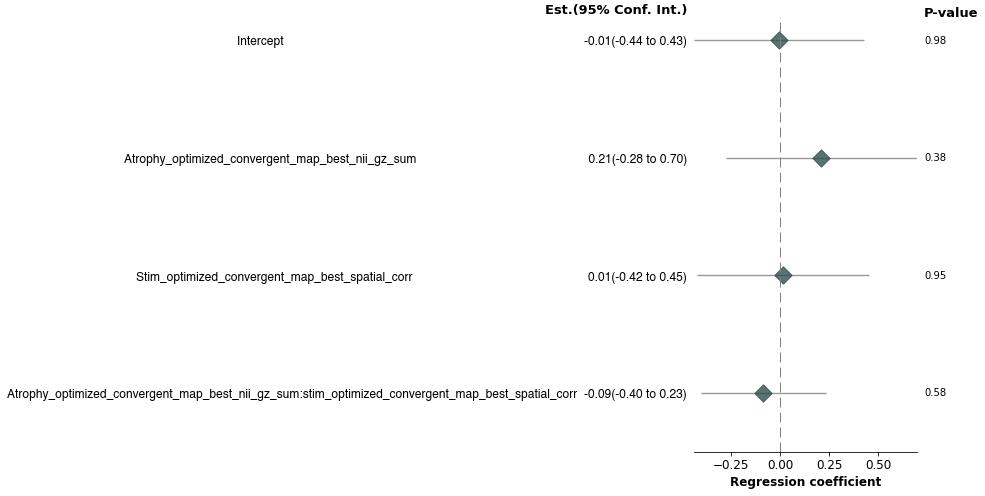

In [29]:
from calvin_utils.statistical_utils.statistical_measurements import ForestPlot
forest = ForestPlot(model=results, sig_digits=2, out_dir=out_dir, table=False)
forest.run()

Visualize The Model's Fit

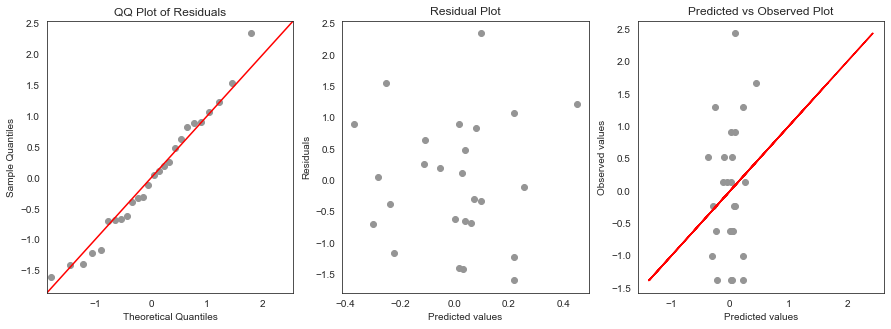

In [30]:
from calvin_utils.statistical_utils.statistical_measurements import model_diagnostics
model_diagnostics(results)

Visualize the Partial Regression Plots

Saved to /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/Jung_TMS_AD/results/adas_cog_scores/memnet_controlled/partial_regression_plot.svg


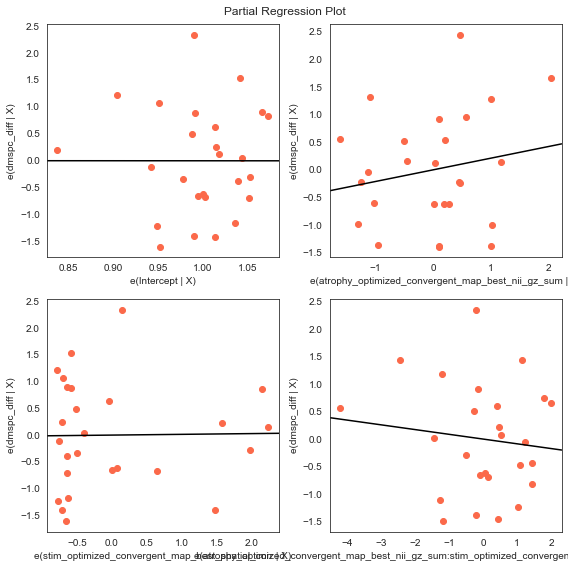

In [31]:
from calvin_utils.statistical_utils.statistical_measurements import PartialRegressionPlot
partial_plot = PartialRegressionPlot(model=results, design_matrix=design_matrix, out_dir=out_dir, palette='Reds')
partial_plot = partial_plot.run()

# 07 - Run the Contrasts

Contrast Results Are Displayed Below

In [32]:
contrast_matrix_df

,Intercept,atrophy_optimized_convergent_map_best_nii_gz_sum,stim_optimized_convergent_map_best_spatial_corr,atrophy_optimized_convergent_map_best_nii_gz_sum:stim_optimized_convergent_map_best_spatial_corr
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


In [33]:
contrast_results = results.t_test(contrast_matrix_df)
print(contrast_results.summary())

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0061      0.210     -0.029      0.977      -0.441       0.428
c1             0.2108      0.236      0.895      0.381      -0.278       0.699
c2             0.0140      0.211      0.066      0.948      -0.424       0.451
c3            -0.0863      0.154     -0.562      0.580      -0.405       0.232


# 08 - Compare the Coefficient Between 2 Groups

In [34]:
groups_column = 'Age_Group'

In [35]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import RegressionAnalysis
regression_test = RegressionAnalysis(outcome_df=outcome_matrix, design_df=design_matrix, groups_df=data_df[[groups_column]], N=10000, metric='similarity', two_tail=False, out_dir=out_dir)
regression_test.run()

KeyError: "None of [Index(['Age_Group'], dtype='object')] are in the [columns]"

# 09 - Compare Distribution of T Values Between Groups

In [ ]:
data_df.columns

In [ ]:
plot_together=False
groups_column = 'Age_Group'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import BootstrappedRegressionAnalysis

# Create an instance of BootstrappedRegressionAnalysis
bootstrapped_regression_test = BootstrappedRegressionAnalysis(outcome_df=outcome_matrix, design_df=design_matrix, groups_df=data_df[[groups_column]], N=10000, out_dir=out_dir, plot_together=plot_together)

# Run the bootstrapped regression analysis
df1 = bootstrapped_regression_test.run()

# 10a - Similarity of Response topology Across Cohorts in Dataframe
- Denote the column containing your different cohorts to test across
- Write the formula, excluding the cohort column

In [ ]:
cohort_col = 'City'
formula = "Z_Scored_Percent_Cognitive_Improvement ~ Age*Z_Scored_Subiculum_Connectivity_T"

In [ ]:
from calvin_utils.statistical_utils.response_surface_utils.permute_response_surfaces import GLMPredictionPermutationTest
sim_test = GLMPredictionPermutationTest(data_df=data_df, formula=formula, cohort_col=cohort_col, two_tailed=False, method='pearsonr',
                                        n_permutations=10000)
sim_test.run()

# 10b - Predict Another Dataframe
- Can use this to predict data from a second group, such as the 'other_df' defined in "Step 01, Drop Rows Based on Value of a Column"

In [ ]:
import numpy as np
from scipy.stats import f

def calculate_ssr(observations, predictions):
    """
    Calculate the regression sum of squares.
    This is the sum of squared deviations, with deviation being Y_hat_i - Y_bar
    
    SSR is a measure used to quantify the variance in the observed data that is not explained by the model. 
    It is calculated as the sum of the squares of the differences between the observed values and the model's predictions. 
    The more the 'mean' predicts 
    A lower SSR indicates a better model fit, meaning the model's predictions are closer to the actual observations.
    
    SSR = Σ(y_hat - y_bar)^2 
    
    Parameters:
    - observations (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    
    Returns:
    - float: The calculated SSR.
    """
    y_hat = observations
    y_bar = np.mean(predictions)
    ssr = np.sum((y_hat - y_bar) ** 2)
    return ssr

def calculate_sse(observations, predictions):
    """
    Calculate the sum of squares due to error (SSE).
    
    SSE is a measure of the total deviation of the response values from the fit to the response values. 
    It is calculated as the sum of the squares of the differences between the predicted values and the observed values. 
    A lower SSE indicates a model that more accurately fits the data.
    
    SSE = Σ(y - y_hat)^2
    
    Parameters:
    - observations (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    
    Returns:
    - float: The calculated SSE.
    """
    y = observations
    y_hat = predictions
    sse = np.sum((y - y_hat) ** 2)
    return sse

def calculate_ssto(observations):
    """
    Calculate the total sum of squares (SSTO).
    
    SSTO is a measure of the total variance in the observed data and is used as a comparative tool for model evaluation. 
    It is calculated as the sum of the squares of the differences between the observed values and their overall mean. 
    SSTO is used in the denominator of the coefficient of determination, R^2, which assesses the fit of the model.
    
    SSTO = Σ(y - y_bar)^2
    
    Parameters:
    - observations (array-like): The actual observed outcomes.
    
    Returns:
    - float: The calculated SSTO.
    """
    y = observations
    y_bar = np.mean(y)
    ssto = np.sum((y - y_bar) ** 2)
    return ssto


def calculate_msr(ssr, num_regressors):
    """
    Calculate the mean square due to regression (MSR).
    
    MSR is a measure of the variation explained by the independent variables in the model. It is calculated as the 
    sum of squared residuals (SSR) divided by the degrees of freedom, which is the number of independent variables (regressors) minus one.
    A higher MSR indicates that the model explains a greater amount of variation in the outcome variable.
    
    MSR = SSR / (number of regressors - 1)
    
    Parameters:
    - ssr (float): The sum of squared residuals from the regression model.
    - num_regressors (int): The number of independent variables in the model.
    
    Returns:
    - float: The calculated MSR.
    """
    return ssr / (num_regressors - 1)

def calculate_mse(sse, num_regressors, num_observations):
    """
    Calculate the mean square error (MSE).
    
    MSE is a measure of the average of the squares of the errors, that is, the average squared difference between the observed actual outcomes and the outcomes predicted by the model. It is calculated as the sum of squared errors (SSE) divided by the degrees of freedom, which is the number of observations minus the number of regressors.
    A lower MSE indicates a better fit of the model to the data.
    
    MSE = SSE / (number of observations - number of regressors)
    
    Parameters:
    - sse (float): The sum of squared errors from the regression model.
    - num_regressors (int): The number of independent variables in the model.
    - num_observations (int): The number of observations in the data set.
    
    Returns:
    - float: The calculated MSE.
    """
    return sse / (num_observations - num_regressors)

def calculate_f_stat(msr, mse, num_regressors, num_observations):
    """
    Calculate the F-statistic.
    
    The F-statistic is used to compare statistical models that have been fitted to a data set in order to identify the model that best fits the population from which the data were sampled. It is the ratio of the mean square due to regression (MSR) to the mean square error (MSE).
    
    The F-statistic follows the F-distribution under the null hypothesis that the model with no independent variables fits the data as well as your model. A higher F-statistic implies that the null hypothesis is false, and your model adds value in explaining the variation in the data.
    
    F = MSR / MSE
    
    Parameters:
    - msr (float): The mean square due to regression.
    - mse (float): The mean square error.
    
    Returns:
    - float: The calculated F-statistic.
    - float: The p-value from the F-distribution.
    """
    f_stat = msr / mse
    # The degrees of freedom for the numerator (dfn) is the number of independent variables (regressors).
    # The degrees of freedom for the denominator (dfd) is the total number of observations minus the number of independent variables minus 1.
    # These values need to be defined or calculated outside of this function.
    dfn = num_regressors - 1
    dfd = num_observations - num_regressors 
    p_value = f.sf(f_stat, dfn, dfd)
    return f_stat, p_value

def run_goodness_of_fit(target_outcome_matrix, predictions, target_design_matrix):
    """
    Calculate the F-statistic and p-value for a linear regression model.

    Parameters:
    - target_outcome_matrix (array-like): The actual observed outcomes (Y_actual).
    - predictions (array-like): The outcomes predicted by the model (Y_hat).

    Returns:
    - float: The calculated F-statistic.
    - float: The p-value from the F-distribution.
    """
    # Calculate the regression sum of squares (SSR).
    ssr = calculate_ssr(target_outcome_matrix, predictions)

    # Calculate the sum of squares due to error (SSE).
    sse = calculate_sse(target_outcome_matrix, predictions)

    # Calculate the number of regressors and observations.
    num_regressors = target_design_matrix.shape[1]
    num_observations = len(target_outcome_matrix)

    # Calculate the mean square due to regression (MSR).
    msr = calculate_msr(ssr, num_regressors)

    # Calculate the mean square error (MSE).
    mse = calculate_mse(sse, num_regressors, num_observations)

    # Calculate the F-statistic and p-value.
    f_stat, p_value = calculate_f_stat(msr, mse, num_regressors, num_observations)

    return f_stat, p_value

def calculate_r_squared(observations, predictions):
    """
    Calculate the R-squared (coefficient of determination) value.

    R-squared measures the proportion of the variance in the observed outcomes that is explained by the predictions.

    R-squared = 1 - (SSE / SSTO)

    Parameters:
    - observations (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.

    Returns:
    - float: The calculated R-squared value.
    """
    # Calculate SSE (Sum of Squares of Errors)
    sse = np.sum((observations - predictions) ** 2)

    # Calculate SSTO (Total Sum of Squares)
    y_mean = np.mean(observations)
    ssto = np.sum((observations - y_mean) ** 2)

    # Calculate R-squared
    r_squared = 1 - (sse / ssto)
    
    return r_squared

Get a new Dataframe to predict upon

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()

In [ ]:
column = 'Cohort'  # The column you'd like to evaluate
condition = 'not'  # The condition to check ('equal', 'above', 'below', 'not')
value = 0 # The value to drop if T

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
display(data_df)

In [ ]:
# Define the design matrix
target_outcome_matrix, target_design_matrix = cal_palm.define_design_matrix(formula, data_df)
predictions = results.predict(target_design_matrix)

Extract F-Test for Goodness of Fit

In [ ]:
f_stat, p_value = run_goodness_of_fit(target_outcome_matrix=target_outcome_matrix.to_numpy().flatten(), 
                    predictions=predictions.to_numpy().flatten(), 
                    target_design_matrix=target_design_matrix)
print(p_value)

Extract R-Squared

In [ ]:
from scipy.stats import pearsonr
r_squared = calculate_r_squared(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten())
print(f"R-squared: {r_squared:.4f}")
r, p = pearsonr(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten())
print(f"PearsonR R-squared: {r*r}")

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(target_outcome_matrix, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(target_outcome_matrix, predictions)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Plot The Fit

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_with_f_stat_in_title(target_outcome_matrix, predictions, f_stat, p_value, out_dir=None):
    """
    Create a scatterplot of predicted vs. observed values with F-statistic and p-value in the title.

    Parameters:
    - target_outcome_matrix (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    - f_stat (float): The F-statistic value.
    - p_value (float): The p-value.

    Returns:
    - None (displays the plot)
    """
    # Create a scatterplot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=predictions,
                    y=target_outcome_matrix,
                    label='Predicted vs. Observed')

    # Add a diagonal line
    xlim = plt.xlim()  # Get current X-axis limits
    ylim = plt.ylim()  # Get current Y-axis limits
    min_limit = min(xlim[0], ylim[0])
    max_limit = max(xlim[1], ylim[1])
    plt.plot([min_limit, max_limit], [min_limit, max_limit], linestyle='--', color='gray', label='Perfect Fit')

    # Add labels and title with F-statistic and p-value
    plt.xlabel('Predicted Values')
    plt.ylabel('Observed Values')
    plt.title(f'Scatterplot of Predicted vs. Observed Values\nF-statistic: {f_stat:.2f}, p-value: {p_value:.4f}')

    # Set axis limits
    plt.xlim(min_limit, max_limit)
    plt.ylim(min_limit, max_limit)

    # Show legend
    plt.legend()
    
    if out_dir:
        # Save the figure
        plt.savefig(f"{out_dir}/predicted_plot.png", bbox_inches='tight')
        plt.savefig(f"{out_dir}/predicted_plot.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/predicted_plot.svg')

    # Display the plot
    plt.grid()
    plt.show()

def plot_residuals(target_outcome_matrix, predictions, f_stat, p_value, out_dir=None):
    """
    Create a scatterplot of residuals with F-statistic and p-value in the title and save it.

    Parameters:
    - target_outcome_matrix (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    - f_stat (float): The F-statistic value.
    - p_value (float): The p-value.
    - out_dir (str, optional): The directory to save the plot. If None, the plot won't be saved.

    Returns:
    - None (displays the plot)
    """
    # Calculate residuals
    residuals = target_outcome_matrix - predictions

    # Create a scatterplot of residuals
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=predictions,
                    y=residuals,
                    label='Residuals vs. Predicted')

    # Calculate y-axis limits
    y_lim_min = min(-3, np.min(residuals) - 0.5)
    y_lim_max = max(3, np.max(residuals) + 0.5)

    # Set y-axis limits
    plt.ylim(y_lim_min, y_lim_max)

    # Add a horizontal line at y=0
    plt.axhline(0, color='gray', linestyle='--', label='Zero Residual')

    # Add labels and title with F-statistic and p-value
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Scatterplot of Residuals vs. Predicted Values\nF-statistic: {f_stat:.2f}, p-value: {p_value:.4f}')

    # Show legend
    plt.legend()

    if out_dir:
        # Save the figure
        plt.savefig(f"{out_dir}/residuals_plot.png", bbox_inches='tight')
        plt.savefig(f"{out_dir}/residuals_plot.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/residuals_plot.svg')

    # Display the plot
    plt.grid()
    plt.show()

Residuals Plot

In [ ]:
plot_residuals(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten(), f_stat, p_value, out_dir)

In [ ]:
plot_scatter_with_f_stat_in_title(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten(), f_stat, p_value, out_dir)


# 11 - Visualize 2-Way ANOVA (Model-Free)

Generate an Interaction Plot Based on the Raw Data (Model-Free)
- data_df (pd.DataFrame): DataFrame containing the data.
- group1_column (str): Name of the first grouping column (categorical).
- group2_column (str): Name of the second grouping column (categorical).
- outcome_column (str): Name of the outcome column (continuous).

In [ ]:
formula

In [ ]:
data_df=data_df
group_1='Age_Group'
group_2='Subiculum_Group_By_24'
outcome_column='City'

In [ ]:
from calvin_utils.statistical_utils.anova_visualization import ModelFreeInteractionPlot
summary_df = ModelFreeInteractionPlot.calculate_means_and_sem(data_df, group_1, group_2, outcome_column)
# Ensure Data is Okay
ModelFreeInteractionPlot.diagnose_data(data_df, group_1, group_2, outcome_column)
# Plot
ModelFreeInteractionPlot.plot_interaction_error_bar(summary_df, group_1, group_2, out_dir=out_dir)
# Test for differences in group_1 at each level of group_2. 
print(ModelFreeInteractionPlot.perform_kruskal_wallis_test(data_df, group_1, group_2, outcome_column))
# Test for significant differences 
print(ModelFreeInteractionPlot.perform_contrast(data_df, contrast_column=group_1, outcome_column=outcome_column))

# Visualize a Modelled ANOVA (Predictions upon Existing Data Points)
- The class expects the a dataframe containing all of the columns with your regressors (or more columns)
- fit a formula onto a model
    - Example: 'Z_Scored_Percent_Cognitive_Improvement ~ Age_Group*Subiculum_Group_By_24 + City'
- Then, you must plot model's predictions of the observed data
    - Mandatory:
        - x_var: the factors
        - hue_var: the levels
    - Optional:
        - cohort_var: additional traces for cohorts
        - y: defaults to 'predictions', and sets the y-axis to the estimated marginal means of the model. Can set to another column in data_df. 
- Bars represent 95%CI
- note: you do not need the input variables to be part of the dataframe. You can model predictions then split by other variables!

In [ ]:
data_df.columns

In [ ]:
formula

In [ ]:
from calvin_utils.statistical_utils.anova_visualization import QuickANOVAPlot
import statsmodels.formula.api as smf

model = smf.ols(formula, data=data_df).fit()

quick_plot = QuickANOVAPlot(model, data_df, out_dir=out_dir)
quick_plot.make_predictions()
quick_plot.plot_predictions(x_var='atrophy_optimized_convergent_map_best_nii_gz_sum', hue_var='stim_optimized_convergent_map_best_spatial_corr', cohort_var=None, y='adascog__diff', error_bar='se')


Visualize as a Bar Plot

In [ ]:
quick_plot.plot_bar(x_var='Subiculum_Group_By_Inflection_Point', hue_var='City', cohort_var=None, y='predictions', error_bar=None)

Read the Regression Results

In [ ]:
print(model.summary2())

# 12 - Visualize a GLM's Predictions Across a Range of Potential Data (AKA Profile Plot or Marginal Plot)
- **this is pretty complex stuff, so be sure to read up on Marginals**
- This is a plot which generates an estimated marginal estimate across a set number of categories/factors
    - This is similar to a marginal mean, but a marginal mean provides the 
- Do **not** set any values to a list of strings. If you want to use categorical data, encode the categories as ordinal values and re-run the model. Then set the categories in the values.

In [ ]:
formula

In [ ]:
marginal_scenarios_dict = {'Age_Group': [0, 1],'City':[0, 1], 'Z_Scored_Subiculum_Connectivity_T':['continuous']}

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import GLMMarginalsPlot
factor_plot = GLMMarginalsPlot(formula, data_df, model=results, data_range=None, marginal_scenarios_dict=marginal_scenarios_dict, variance_bars=None, out_dir=out_dir)
factor_plot.run()

# Visualize a GLM's Predictions at Points in Data (Estimated Marginal Means)

Interaction Plot

Identify the column names used to generate the original formula. The order of the list determines how variables are categorized in the following interaction plot. 
- This expects the formula to have defined categorical variables, like:
    - Z_Scored_Percent_Cognitive_Improvement ~ C(Subiculum_Group_By_24)*Age + C(City)

In [ ]:
formula

In [ ]:
def create_interaction_plot_dynamic(emm_df, categorical_vars, out_dir=None):
    """
    Create an interaction plot for 2 or 3 categorical variables in emm_df.

    Parameters:
    - emm_df: DataFrame containing the data
    - categorical_vars: List of strings specifying the categorical variables
    - ms: Marker size for the plot (default is 10)
    """
    # Check if we have 2 or 3 categorical variables
    if len(categorical_vars) == 2:
        plot_interaction_2_vars(emm_df, categorical_vars, out_dir)
    elif len(categorical_vars) == 3:
        self.plot_interaction_3_vars(emm_df, categorical_vars,out_dir)
    else:
        print("This function supports only 2 or 3 categorical variables.")
        

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

def plot_interaction_2_vars(emm_df, categorical_vars, output_directory=None, color_list = None):
    """
    Plots an interaction bar plot for two categorical variables in an ANOVA setup.

    Parameters:
        emm_df (DataFrame): The DataFrame containing the data.
        categorical_vars (list): A list of two categorical variable names to plot.
        color_list (list, optional): List of colors for the bars. If None, defaults to tab10 colormap.
        output_directory (str, optional): Directory to save the plot. If None, plot is not saved.
    """
    # Set up the color palette
    if color_list is None:
        color_palette = sns.color_palette("tab10", len(emm_df[categorical_vars[1]].unique()))
    else:
        color_palette = sns.color_palette(color_list, len(emm_df[categorical_vars[1]].unique()))

    # color_palette = sns.color_palette("tab10")
    
    # Initialize the plot
    plt.figure(figsize=(10, 8))

    # Create the bar plot
    sns.barplot(
        data=emm_df,
        x=categorical_vars[0],
        y='predictions',
        hue=categorical_vars[1],
        palette=color_palette
    )

    # Customize the plot
    plt.xlabel(categorical_vars[0])
    plt.ylabel('Predictions')
    plt.title(f'Interaction Bar Plot of Predicted EMMs ({categorical_vars[1]})')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot if output_directory is provided
    if output_directory:
        plt.savefig(f"{output_directory}/interaction_bar_plot.png", bbox_inches='tight')
        plt.savefig(f"{output_directory}/interaction_bar_plot.svg", bbox_inches='tight')
        print(f'Saved to {output_directory}/interaction_bar_plot.png and {output_directory}/interaction_bar_plot.svg')

    # Show the plot
    plt.show()

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import EstimatedMarginalMean

interaction_plot = EstimatedMarginalMean(formula, data_df, model=results)
interaction_plot.extract_unique_variables()
interaction_plot.create_emm_df(plus_2_stdev=True, minus_2_stdev=False)
interaction_plot.define_design_matrix()
interaction_plot.predict_emm_design_df()
categorical_columns = interaction_plot.variables_df[interaction_plot.variables_df['Type'] == 'categorical']['Variable'].tolist()

create_interaction_plot_dynamic(emm_df=interaction_plot.emm_df.dropna(), categorical_vars=categorical_columns, out_dir=out_dir)

In [ ]:
interaction_plot.emm_df

# 12 - Get Zero Points of Each Coefficient

The zero point is the point where the coefficient cross zero.
When the response topology has a saddle point, the zero point indicates where the saddle is. 
Technically, the linear regression's formula does not have a saddle point. 
However, if you rotate the response topology which exhibits a saddle point by 45 degrees, you will observe a saddle point in orientation with the Cartesian plane. 

In [ ]:
from calvin_utils.statistical_utils.calculus_utils import find_zero_point_of_coefficients
find_zero_point_of_coefficients(results)

# 13 - Compare 2 Different Sets of Regressors

In [ ]:
data_df.columns

In [ ]:
formula

For Nested Models

In [ ]:
from statsmodels.stats.api import anova_lm
import statsmodels.formula.api as smf

smaller_formula = 'TOTALMOD ~ CSFGM_MTL + CSFGM_Frontal + CSFGM_Occipital + CSFGM_Parietal + CSFGM_Temporal'

larger_formula = 'TOTALMOD ~ CSF_MTL + CSF_Frontal + CSF_Occipital + CSF_Parietal + CSF_Temporal'

#----------------------------------------------------------------DO NOT TOUCH!----------------------------------------------------------------
table1 = anova_lm(smf.ols(smaller_formula, data=data_df).fit(), smf.ols(larger_formula, data=data_df).fit())
print(table1)

For Un-nested Models
- Need to employ permutation because there is no existing method. 

In [ ]:
data_df.columns

In [ ]:
formula

In [ ]:
formula1 = 'TOTALMOD ~ CSFGM_MTL + CSFGM_Frontal + CSFGM_Occipital + CSFGM_Parietal + CSFGM_Temporal'
formula2 = 'TOTALMOD ~ CSF_MTL + CSF_Frontal + CSF_Occipital + CSF_Parietal + CSF_Temporal'

In [ ]:
import numpy as np
from tqdm import tqdm
import statsmodels.formula.api as smf

# Original R^2 values from the models
r2_model1 = smf.ols(formula1, data=data_df).fit().rsquared
r2_model2 = smf.ols(formula2, data=data_df).fit().rsquared

# Difference in R of original models
original_diff = r2_model1 - r2_model2

# Number of permutations
n_permutations = 1000

# Store differences from permutations
perm_diffs = []
for i in tqdm(range(n_permutations)):
    # Permute the outcome variable
    data_df_permuted = data_df.copy()
    data_df_permuted['TOTALMOD'] = np.random.permutation(data_df_permuted['TOTALMOD'].values)
    
    # Fit the models to the permuted dataset and calculate R^2
    perm_model1 = smf.ols(formula1, data=data_df_permuted).fit()
    perm_model2 = smf.ols(formula2, data=data_df_permuted).fit()
    
    # Difference in R^2 for the permuted models
    perm_diff = perm_model1.rsquared - perm_model2.rsquared
    
    # Store the difference
    perm_diffs.append(perm_diff)

# Calculate the p-value as the proportion of permuted differences
# that are greater than or equal to the observed difference
p_value = np.mean([abs(diff) >= abs(original_diff)for diff in perm_diffs])
print(f"Original R Difference: {original_diff}")
print(f"P-value from permutation test: {p_value}")

In [ ]:
r2_model1

In [ ]:
np.sqrt(.30)

In [ ]:
r2_model2

Estimate Uncertainty Around a Regression Metric with Bootstrapping
- R-squared approach visualized below. 

In [ ]:
#Testing
import numpy as np
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.utils import resample

def bootstrap_r_squared(data: pd.DataFrame, formula: str, n_bootstraps: int = 1000):
    """
    Perform bootstrap resampling to calculate the 95% confidence interval for R-squared.

    Parameters:
    - data (pd.DataFrame): The primary dataframe containing the data.
    - formula (str): The formula specifying the model (e.g., 'Y ~ X1 + X2').
    - n_bootstraps (int): The number of bootstrap samples (default is 10,000).

    Returns:
    - dict: A dictionary containing the original R-squared, the mean R-squared, the 95% confidence interval,
            the standard deviation, and the standard error of R-squared.
    """
    # Original model
    model = sm.OLS.from_formula(formula, data)
    original_results = model.fit()
    print("Original R^2:", original_results.rsquared)

    # Bootstrapping
    r_squared_values = []
    for _ in tqdm(range(n_bootstraps)):
        # Resample the dataframe with replacement
        boot_data = resample(data, replace=True, n_samples=len(data))
        
        # Fit the model to the bootstrapped sample
        boot_model = sm.OLS.from_formula(formula, boot_data)
        boot_results = boot_model.fit()
        
        # Store the R-squared
        r_squared_values.append(boot_results.rsquared)

    # Calculate the 95% confidence interval for R^2
    r_squared_lower = np.percentile(r_squared_values, 2.5)
    r_squared_upper = np.percentile(r_squared_values, 97.5)

    result = {
        "Original R^2": original_results.rsquared,
        "Mean R^2": np.mean(r_squared_values),
        "95% CI": (r_squared_lower, r_squared_upper),
        "Stdev": np.std(r_squared_values),
        "StdErr R^2": np.std(r_squared_values) / np.sqrt(len(r_squared_values))
    }

    print(f"95% CI for R^2: ({r_squared_lower:.4f}, {r_squared_upper:.4f})")
    print(f"Mean R^2: {np.mean(r_squared_values)} | Stdev: {np.std(r_squared_values)} | StdErr R^2: {np.std(r_squared_values)/np.sqrt(len(r_squared_values))}")

    return result

bootstrap_r_squared(data_df, formula5)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 10000
r_squared_values = []

# Original model
model = sm.OLS(outcome_matrix, design_matrix)
original_results = model.fit()
print("Original R^2:", original_results.rsquared)

# Bootstrapping
for _ in range(n_bootstraps):
    # Resample the indices with replacement
    boot_indices = np.random.choice(len(outcome_matrix), size=len(outcome_matrix), replace=True)
    if isinstance(outcome_matrix, pd.DataFrame):
        boot_outcome = outcome_matrix.iloc[boot_indices]
    else:
        boot_outcome = outcome_matrix[boot_indices]
    
    if isinstance(design_matrix, pd.DataFrame):
        boot_design = design_matrix.iloc[boot_indices]
    else:
        boot_design = design_matrix[boot_indices]

    # Fit the model to the bootstrapped sample
    boot_model = sm.OLS(boot_outcome, boot_design)
    boot_results = boot_model.fit()
    
    # Store the R-squared
    r_squared_values.append(boot_results.rsquared)

# Calculate the 95% confidence interval for R^2
r_squared_lower = np.percentile(r_squared_values, 2.5)
r_squared_upper = np.percentile(r_squared_values, 97.5)

print(f"95% CI for R^2: ({r_squared_lower:.4f}, {r_squared_upper:.4f})")
print(f"Mean R^2: {np.mean(r_squared_values)} | Stdev: {np.std(r_squared_values)} | StdErr R^2: {np.std(r_squared_values)/len(r_squared_values)}")

Test the means

In [ ]:
import numpy as np
from scipy.stats import t

def two_sample_t_test(n1, n2, mean1, mean2, stdev1, stdev2):
    t_stat = (mean1 - mean2) / np.sqrt((stdev1**2/n1 + stdev2**2/n2))
    
    dof = n1 + n2 - 2
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), dof))
    return t_stat, p_value

t_stat, p_value = two_sample_t_test(n1=10, n2=10, mean1=0.16, mean2=0.23, stdev1=0.09, stdev2=0.09)
print("t-statistic:", t_stat)
print("p-value:", p_value)


In [ ]:
np.sqrt(.11)